In [1]:
import pandas as pd


In [2]:
pip install pandas numpy scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('./df_24m_c.csv')

In [4]:
df.head()



Closed Status  Duration  Start Station Id           Start Date  \
0        NORMAL      9.37                40  2023-12-31 23:24:00   
1        NORMAL      2.57                51  2023-12-31 23:11:00   
2        NORMAL     15.57                27  2023-12-31 22:46:00   
3        NORMAL     36.63                21  2023-12-31 22:45:00   
4        NORMAL     37.87                21  2023-12-31 22:43:00   

                     Start Station Name          End Date  End Station Id  \
0                     7th St & Penn Ave  12/31/2023 23:33            58.0   
1              Coltart Ave & Forbes Ave  12/31/2023 23:14            10.0   
2  W Station Square Dr & Bessemer Court  12/31/2023 23:02            27.0   
3              Liberty Ave & Stanwix St  12/31/2023 23:21            21.0   
4              Liberty Ave & Stanwix St  12/31/2023 23:21            21.0   

                       End Station Name  acct ID Rider Type Bike Model  \
0              W North Ave & Federal St    51630     MEMBER       EFIT   
1               Zulema St & Coltart Ave    47239     MEMBER       EFIT   
2  W Station Square Dr & Bessemer Court     2148     MEMBER       EFIT   
3              Liberty Ave & Stanwix St    19275     CASUAL        FIT   
4              Liberty Ave & Stanwix St    19275     CASUAL        FIT   

                  Product Name  
0                    Flex Pass  
1                    Flex Pass  
2  Mobility Justice Membership  
3                  Single Ride  
4                  Single Ride

In [5]:
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")

# Extract month as "YYYY-MM"
df["month"] = df["Start Date"].dt.to_period("M")


In [6]:

start = df.groupby(["Start Station Id", "month"]).size().reset_index(name="start_rides")
end = df.groupby(["End Station Id", "month"]).size().reset_index(name="end_rides")

rides = (
    pd.merge(start, end, left_on=["Start Station Id", "month"], right_on=["End Station Id", "month"], how="outer")
      .assign(
          station_id=lambda d: d["Start Station Id"].combine_first(d["End Station Id"]),
          total_rides=lambda d: d["start_rides"].fillna(0) + d["end_rides"].fillna(0)
      )[["station_id", "month", "total_rides"]]
      .sort_values(["station_id", "month"])
)

# Baseline: previous month's rides
rides["baseline"] = rides.groupby("station_id")["total_rides"].shift(1)

# Growth metrics
rides["growth"] = rides["total_rides"] - rides["baseline"]
rides["growth_rate"] = rides["growth"] / rides["baseline"] * 100

rides = rides.dropna(subset=["baseline"])  # remove the first month per station (no previous data)

rides


/var/folders/lx/jsqz5w414md26yj6mvbz6tbw0000gn/T/ipykernel_58808/3069538044.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  station_id=lambda d: d["Start Station Id"].combine_first(d["End Station Id"]),


station_id    month  total_rides  baseline  growth  growth_rate
1              1  2023-09        304.0     126.0   178.0   141.269841
2              1  2023-10        447.0     304.0   143.0    47.039474
3              1  2023-11        276.0     447.0  -171.0   -38.255034
4              1  2023-12        193.0     276.0   -83.0   -30.072464
5              1  2024-01        206.0     193.0    13.0     6.735751
...          ...      ...          ...       ...     ...          ...
1432          60  2025-03         71.0      25.0    46.0   184.000000
1433          60  2025-04        112.0      71.0    41.0    57.746479
1434          60  2025-05        137.0     112.0    25.0    22.321429
1435          60  2025-06        224.0     137.0    87.0    63.503650
1436          60  2025-07        199.0     224.0   -25.0   -11.160714

[1377 rows x 6 columns]

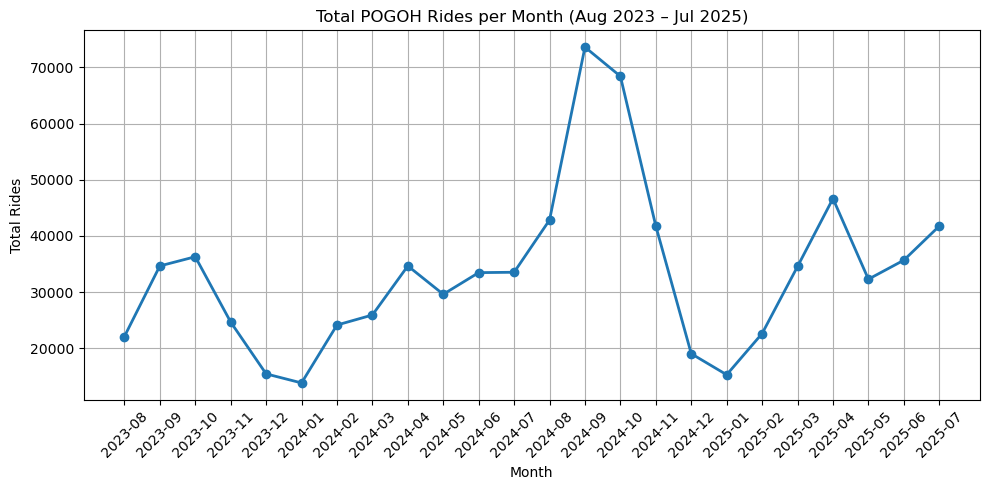

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("df_24m_c.csv")
df["Start Date"] = pd.to_datetime(df["Start Date"], errors="coerce")

# Keep only valid records
df = df[df["Closed Status"] == "NORMAL"]

# Extract month as Period
df["month"] = df["Start Date"].dt.to_period("M")

# Group by month (count rides)
monthly = df.groupby("month", as_index=False).size().rename(columns={"size": "total_rides"})

# --- HERE’S THE FIX: make sure every month appears ---
all_months = pd.period_range(start="2023-08", end="2025-07", freq="M")
monthly = monthly.set_index("month").reindex(all_months, fill_value=0).reset_index()
monthly.rename(columns={"index": "month"}, inplace=True)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly["month"].astype(str), monthly["total_rides"], marker="o", linewidth=2)
plt.xticks(rotation=45)
plt.title("Total POGOH Rides per Month (Aug 2023 – Jul 2025)")
plt.xlabel("Month")
plt.ylabel("Total Rides")
plt.grid(True)
plt.tight_layout()
plt.show()



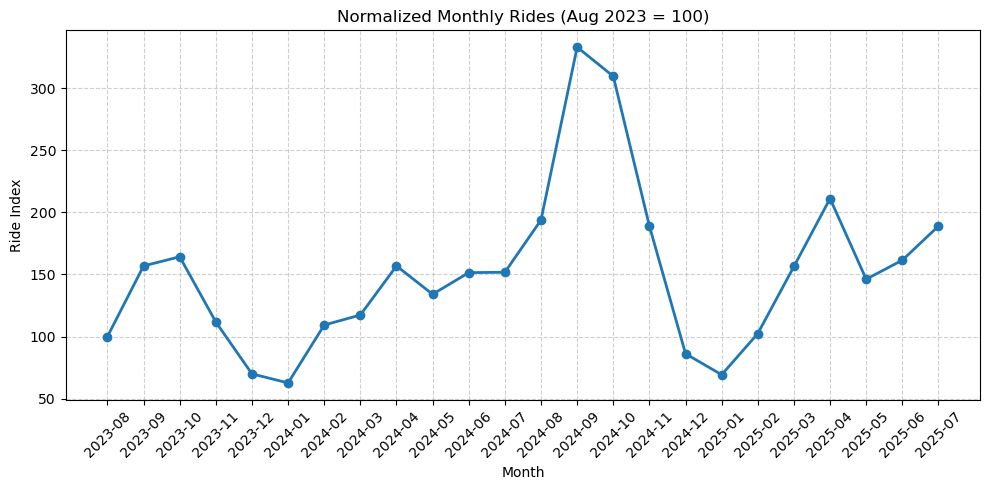

In [8]:
monthly = df.groupby("month", as_index=False).size().rename(columns={"size": "total_rides"})

# --- Make sure every month Aug 2023 – Jul 2025 appears ---
all_months = pd.period_range("2023-08", "2025-07", freq="M")
monthly = monthly.set_index("month").reindex(all_months, fill_value=0).reset_index()
monthly.rename(columns={"index": "month"}, inplace=True)

# --- Normalize (Aug 2023 = 100) ---
base = monthly.loc[monthly["month"] == pd.Period("2023-08"), "total_rides"].iloc[0]
monthly["index_100"] = monthly["total_rides"] / base * 100

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(monthly["month"].astype(str), monthly["index_100"], marker="o", linewidth=2)
plt.title("Normalized Monthly Rides (Aug 2023 = 100)")
plt.xlabel("Month")
plt.ylabel("Ride Index")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

# Suppose your trip-level or station-month dataframe is df
# It has a datetime column like "Start Date"

df["month"] = pd.to_datetime(df["Start Date"]).dt.month
df["year"] = pd.to_datetime(df["Start Date"]).dt.year

# Create a categorical month variable so model knows seasonal effect
df["month_cat"] = df["month"].astype("category")

# Option 1: One-hot encode months (so model learns seasonal differences)
df = pd.get_dummies(df, columns=["month_cat"], prefix="m", drop_first=True)


### Decide the target → what you want to predict (e.g., total rides per station per month).

### Pick predictor variables → what features might explain that (e.g., population density, station_category, neighborhood, etc.).

### Split data → training 70 %, validation 15 %, test 15 %.

### Build the baseline model → simplest regression to predict rides.

In [39]:
merged=pd.read_csv('merged.csv')

In [41]:
import pandas as pd

# Work on a local copy; do NOT modify `merged`
m2 = merged.copy()

# 1) Standardize ID + Name columns (safe Int64 with NA support)
m2["station_id"] = pd.to_numeric(m2["start_station_id"], errors="coerce").astype("Int64")
m2["station_name"] = m2["name"]

# 2) Compute avg_monthly_rides from total_rides across months (if not present)
if "avg_monthly_rides" not in m2.columns:
    avg = (
        m2.groupby("station_id", dropna=True, as_index=False)["total_rides"]
          .mean()
          .rename(columns={"total_rides": "avg_monthly_rides"})
    )
    m2 = m2.merge(avg, on="station_id", how="left")

# 3) Build final selection (use exactly your column names)
cols_needed = [
    "station_id",
    "station_name",
    "avg_monthly_rides",
    "density_category",
    "university_dist_mi",
    "community_name",
    "station_category",
    "latitude",
    "longitude"
]

# keep rows where station_id exists
out = (
    m2[cols_needed]
    .dropna(subset=["station_id", "avg_monthly_rides"])
    .drop_duplicates(subset=["station_id"])
)

# 4) Cleanups
out = out[out["station_id"] != 61]  # remove bad id 61

# Round safely to 0 decimals; keep as int
out["avg_monthly_rides"] = out["avg_monthly_rides"].round(0).astype(int)

# 5) Sort and save
out = out.sort_values("avg_monthly_rides", ascending=False)
out["university_dist_mi"] = out["university_dist_mi"].round(2)
out.to_csv("monthly_avg_with_density.csv", index=False)

print("✅ Saved 'monthly_avg_with_density.csv' — sorted, rounded, with required columns.")
print(out.head(10))
out.info()


✅ Saved 'monthly_avg_with_density.csv' — sorted, rounded, with required columns.
      station_id                            station_name  avg_monthly_rides  \
288           13              S Bouquet Ave & Sennott St               3158   
456           20  Boulevard of the Allies & Parkview Ave               2249   
1173          50                    Atwood St & Bates St               2139   
264           12            O'Hara St & University Place               1779   
790           34             N Dithridge St & Centre Ave               1744   
670           29           Filmore St & S Bellefield Ave               1650   
216           10                 Zulema St & Coltart Ave               1497   
648           28                Fifth Ave & S Bouquet St               1496   
1197          51                Coltart Ave & Forbes Ave               1359   
886           38              Allequippa St & Darragh St               1148   

      density_category  university_dist_mi commun

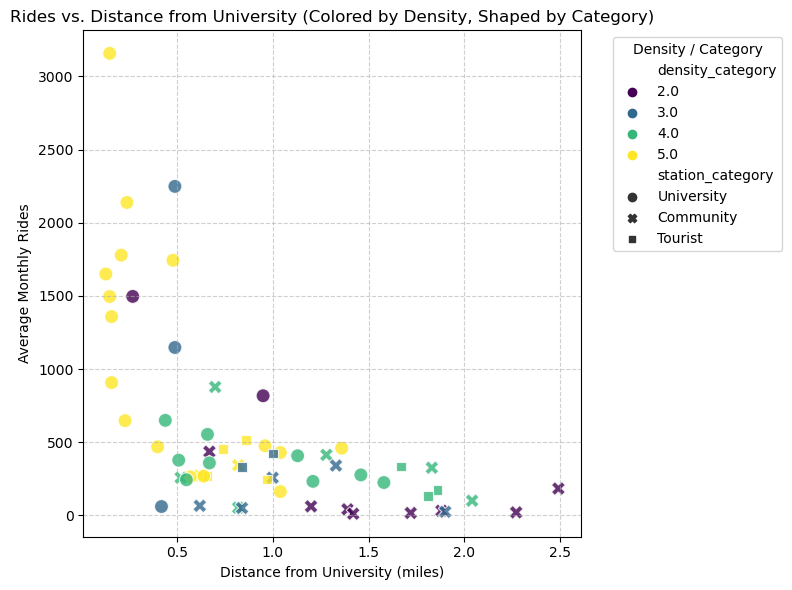

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("monthly_avg_with_density.csv")

# Clean and prepare
df["density_category"] = pd.to_numeric(df["density_category"], errors="coerce")
df["university_dist_mi"] = pd.to_numeric(df["university_dist_mi"], errors="coerce")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="university_dist_mi",
    y="avg_monthly_rides",
    hue="density_category",
    style="station_category",
    palette="viridis",
    s=100,
    alpha=0.8
)

plt.title("Rides vs. Distance from University (Colored by Density, Shaped by Category)")
plt.xlabel("Distance from University (miles)")
plt.ylabel("Average Monthly Rides")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Density / Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### looking for high or very high density neighbourhood nearby

In [50]:
pip install geopy pandas

Note: you may need to restart the kernel to use updated packages.


In [69]:
# ============================================
# Modeling + Expansion (Population-only logic)
# ============================================
# Inputs (same folder):
#   - monthly_avg_with_density.csv
#       station_id, station_name, avg_monthly_rides, university_dist_mi, community_name, (density_category ignored)
#   - neighborhood_model.csv
#       Neighborhood, stations_within_radius, pop2020, min_university_dist_mi, ...
#
# Outputs:
#   - station_training_frame.csv
#   - expansion_priority_population_only.csv
#
# Notes:
# - Population and density overlap → we DO NOT use density anywhere.
# - Model trains on stations with: avg_monthly_rides ~ university_dist_mi
# - Candidates = neighborhoods NOT in station table AND stations_within_radius > 0 (connected).
# - Score = PredictedRides + 0.4*(pop2020/1000) - 100*university_dist_mi
# - If you later compute stations_within_radius at 0.6mi instead of 0.5mi, this script will use it automatically.

# ============================================
# Modeling + Expansion (Population-only logic) — robust column mapper
# ============================================
# Inputs (same folder):
#   - monthly_avg_with_density.csv
#       station_id, station_name, avg_monthly_rides, university_dist_mi, community_name, (density_category ignored)
#   - neighborhood_model.csv
#       <any reasonable names> e.g.,
#       Neighborhood|neighborhood|community, stations_within_radius|stations_within_0_5mi|stations_within,
#       pop2020|population_2020|population, min_university_dist_mi|university_dist_mi|min_univ_dist
#
# Outputs:
#   - station_training_frame.csv
#   - expansion_priority_population_only.csv
#
# Notes:
# - No density is used anywhere.
# - Model: avg_monthly_rides ~ university_dist_mi  (trained on existing stations)
# - Candidates = neighborhoods NOT in station table AND stations_within_radius > 0 (connected).
# - Score = PredictedRides + 0.4*(pop2020/1000) - 100*university_dist_mi
# - If you later compute stations_within_radius at 0.6mi instead of 0.5mi, this script will use it automatically.

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from pathlib import Path

# ------------- Config -------------
PATH_STATIONS = "monthly_avg_with_density.csv"
PATH_NEIGH    = "neighborhood_model.csv"

OUT_TRAIN     = "station_training_frame.csv"
OUT_EXPANSION = "expansion_priority_population_only.csv"

# ------------- Load ---------------
stations = pd.read_csv(PATH_STATIONS)
neigh    = pd.read_csv(PATH_NEIGH)

# ------------- Helpers -------------
def norm(s: pd.Series) -> pd.Series:
    return s.fillna("").astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

def pick_column(df: pd.DataFrame, priority_names, fuzzy_keys=None):
    """Return first matching column by exact name, else by fuzzy contains of all keys."""
    # exact
    for name in priority_names:
        if name in df.columns:
            return name
    # fuzzy
    if fuzzy_keys:
        keys = [k.lower() for k in fuzzy_keys]
        for col in df.columns:
            low = col.lower()
            if all(k in low for k in keys):
                return col
    return None

# ------------- Standardize station fields -------------
stations["community_norm"] = norm(stations.get("community_name", pd.Series(index=stations.index, dtype=object)))

for c in ["avg_monthly_rides", "university_dist_mi"]:
    if c in stations.columns:
        stations[c] = pd.to_numeric(stations[c], errors="coerce")

# ------------- Standardize neighborhood fields -------------
col_neigh = pick_column(
    neigh,
    ["Neighborhood", "neighborhood", "community", "area", "name"],
    fuzzy_keys=["neigh"]
) or pick_column(neigh, [], fuzzy_keys=["community"])

col_within = pick_column(
    neigh,
    ["stations_within_radius", "stations_within", "stations_within_0_5mi", "stations_within_0.5mi",
     "stations_within_0_6mi", "stations_within_0.6mi", "within_radius"],
    fuzzy_keys=["stations", "within"]
)

col_pop = pick_column(
    neigh,
    ["pop2020", "population_2020", "population", "pop_2020", "pop"],
    fuzzy_keys=["pop"]
)

col_udist = pick_column(
    neigh,
    ["min_university_dist_mi", "university_dist_mi", "min_univ_dist", "min_uni_dist_mi", "min_university_distance_miles"],
    fuzzy_keys=["univ", "dist"]
)

missing = []
if not col_neigh:  missing.append("Neighborhood (or neighborhood/community)")
if not col_pop:    missing.append("pop2020 (or population_2020/population)")
if not col_udist:  missing.append("min_university_dist_mi (or university_dist_mi)")
# stations_within is used for connectivity filter; if missing we treat as 0 (not connected)
if missing:
    raise ValueError(
        "Missing required neighborhood columns:\n - " +
        "\n - ".join(missing) +
        f"\nAvailable columns in neighborhood_model.csv: {list(neigh.columns)}"
    )

# Rename to canonical names used downstream
renamer = {}
renamer[col_neigh] = "Neighborhood"
renamer[col_pop]   = "pop2020"
renamer[col_udist] = "min_university_dist_mi"
if col_within:
    renamer[col_within] = "stations_within_radius"

neigh = neigh.rename(columns=renamer)

# Hygiene
neigh["neigh_norm"] = norm(neigh["Neighborhood"])
for c in ["stations_within_radius", "pop2020", "min_university_dist_mi"]:
    if c in neigh.columns:
        neigh[c] = pd.to_numeric(neigh[c], errors="coerce")

# If we truly have no 'stations_within_radius' column, create it as 0 (disconnected),
# so those rows won't pass the connectivity filter.
if "stations_within_radius" not in neigh.columns:
    neigh["stations_within_radius"] = 0

# ------------- Train OLS (no density) -------------
train = stations.dropna(subset=["avg_monthly_rides", "university_dist_mi"]).copy()
if len(train) < 5:
    raise ValueError(f"Too few rows for training after cleaning: {len(train)}. "
                     "Check avg_monthly_rides/university_dist_mi in monthly_avg_with_density.csv.")
model = smf.ols("avg_monthly_rides ~ university_dist_mi", data=train).fit()

# predictions on existing stations (optional, for QA)
train["predicted_rides"] = model.predict(train[["university_dist_mi"]]).clip(lower=0)
train.to_csv(OUT_TRAIN, index=False)

# ------------- Expansion candidates -------------
served = set(stations["community_norm"].unique())

cand = neigh[
    (~neigh["neigh_norm"].isin(served)) &
    (neigh["stations_within_radius"] > 0)
].copy()

# features for scoring
cand.rename(columns={"min_university_dist_mi": "university_dist_mi"}, inplace=True)

# predict rides with the station-trained model (fill NaN distance with median)
if cand["university_dist_mi"].isna().any():
    cand["university_dist_mi"] = cand["university_dist_mi"].fillna(cand["university_dist_mi"].median())

cand["predicted_rides_if_added"] = model.predict(cand[["university_dist_mi"]]).clip(lower=0)

# ------------- Priority Score (population-only) -------------
cand["score"] = (
    cand["predicted_rides_if_added"]
    + 0.4 * (cand["pop2020"] / 1000.0)
    - 100.0 * cand["university_dist_mi"]
)

# ------------- Rank & Export -------------
cols_out = [
    "Neighborhood",
    "stations_within_radius",
    "pop2020",
    "university_dist_mi",
    "predicted_rides_if_added",
    "score",
]
cand_ranked = cand.sort_values("score", ascending=False).reset_index(drop=True)
cand_ranked = cand_ranked.reindex(columns=cols_out)

cand_ranked.to_csv(OUT_EXPANSION, index=False)

print("Saved:")
print(f" - {OUT_TRAIN}")
print(f" - {OUT_EXPANSION}")
print("\nTop 50 suggestions:")
print(cand_ranked.head(50).to_string(index=False))


Saved:
 - station_training_frame.csv
 - expansion_priority_population_only.csv

Top 50 suggestions:
                            Neighborhood  stations_within_radius  pop2020  university_dist_mi  predicted_rides_if_added       score
                           North Oakland                      15    10691            0.168634               1060.519758 1047.932776
                         Central Oakland                      16     5835            0.419131                898.334395  858.755337
                            West Oakland                      18     2534            0.655526                745.279066  680.740075
                              Upper Hill                      15     1723            0.678223                730.583682  663.450576
                           South Oakland                      14     3329            0.856112                615.408567  531.128960
                         Terrace Village                      14     2320            0.903658               

In [54]:
# =========================
# Next 50 Proposed Stations (population-driven, requires ≥1 nearby station)
# =========================
# Inputs:
#   neighborhood_model.csv
#       - must include: Neighborhood, pop2020
#       - ideally includes: neigh_lat, neigh_lon
#       - proximity: stations_within_1mile (preferred) or stations_within_radius (fallback)
#       - optional: dist_from_pitt_mi or min_university_dist_mi (if present, slight boost)
#   monthly_avg_with_density.csv (or similar)
#       - used ONLY to plot existing stations (auto-detect lat/lon columns)
#
# Outputs:
#   next50_stations.csv
#   next50_stations_map.html

import pandas as pd, numpy as np, folium
from folium.plugins import MarkerCluster

# -------- Config --------
COMM_FILE     = "neighborhood_model.csv"
STATIONS_FILE = "monthly_avg_with_density.csv"   # only for plotting current stations
OUT_CSV       = "next50_stations.csv"
OUT_MAP       = "next50_stations_map.html"
TOP_N         = 50
REQUIRE_NEARBY_STATION = True  # enforce connectivity (≥1 within chosen radius column)

# -------- Load communities --------
comm = pd.read_csv(COMM_FILE)

# Basic checks
if "Neighborhood" not in comm.columns and "community_name" not in comm.columns:
    raise ValueError("neighborhood_model.csv must have 'Neighborhood' or 'community_name' column")
key_col = "Neighborhood" if "Neighborhood" in comm.columns else "community_name"
comm[key_col] = comm[key_col].astype(str).str.strip()

if "pop2020" not in comm.columns:
    raise ValueError("neighborhood_model.csv must include 'pop2020'")

# Neighborhood coordinates (for proposed station points)
lat_col = "neigh_lat" if "neigh_lat" in comm.columns else ( "lat" if "lat" in comm.columns else None )
lon_col = "neigh_lon" if "neigh_lon" in comm.columns else ( "lon" if "lon" in comm.columns else None )

# Proximity column: prefer 1-mile if available
if "stations_within_1mile" in comm.columns:
    prox_col = "stations_within_1mile"
elif "stations_within_radius" in comm.columns:
    prox_col = "stations_within_radius"
else:
    # create a zero column if none exists, but note: then no rows will pass the ≥1 filter
    prox_col = "stations_within_radius"
    comm[prox_col] = 0

# Optional distance-to-Pitt column (light weight in score if present)
dist_cols = [c for c in comm.columns if c.lower() in ("dist_from_pitt_mi","min_university_dist_mi")]
uni_col = dist_cols[0] if dist_cols else None

# Numeric coercions
num_cols = [c for c in [ "pop2020", prox_col, lat_col, lon_col, uni_col ] if c]
for c in num_cols:
    comm[c] = pd.to_numeric(comm[c], errors="coerce")

# -------- Candidate filter: must be connected (≥1 nearby station) --------
eligible = comm.copy()
if REQUIRE_NEARBY_STATION:
    eligible = eligible[eligible[prox_col].fillna(0) >= 1].copy()

# Drop rows without coordinates (cannot propose a lat/lon for a station)
if not lat_col or not lon_col:
    raise ValueError("neighborhood_model.csv must include neighborhood coordinates (neigh_lat, neigh_lon) to propose station points.")
eligible = eligible.dropna(subset=[lat_col, lon_col])

# -------- Scoring (population-dominant) --------
def minmax(s):
    s = pd.to_numeric(s, errors="coerce")
    smin, smax = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(smin) or pd.isna(smax) or smin == smax:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return (s - smin) / (smax - smin)

def inv_dist(s):  # higher score when closer
    s = pd.to_numeric(s, errors="coerce")
    return 1.0 / (1.0 + s)

eligible["pop_score"] = minmax(eligible["pop2020"])

# small bonus if distance-to-Pitt exists (optional)
if uni_col:
    eligible["uni_score"] = minmax(inv_dist(eligible[uni_col]))
else:
    eligible["uni_score"] = 0.0

# saturation penalty: fewer nearby stations → higher priority
eligible["sat_pen"] = minmax(1.0 / eligible[prox_col].clip(lower=1))

# weights (population dominates)
w_pop, w_uni, w_sat = 0.80, 0.10, 0.10
eligible["score"] = w_pop*eligible["pop_score"] + w_uni*eligible["uni_score"] + w_sat*eligible["sat_pen"]

# -------- Select top N proposed station points --------
top = eligible.sort_values("score", ascending=False).head(TOP_N).copy()

# Build proposed station records
top["proposed_station_name"] = "Next Station: " + top[key_col]
top["proposed_lat"] = top[lat_col].astype(float)
top["proposed_lon"] = top[lon_col].astype(float)

# Columns to export
out_cols = [
    "proposed_station_name",
    key_col,
    "score",
    "pop2020",
    prox_col,
]
if uni_col: out_cols.append(uni_col)
out_cols += ["proposed_lat", "proposed_lon"]

top[out_cols].rename(columns={key_col: "Neighborhood"}).to_csv(OUT_CSV, index=False)
print(f"✅ Saved next {TOP_N} proposed stations: {OUT_CSV}")

# -------- Load existing stations (for map layer only) --------
st = pd.read_csv(STATIONS_FILE)
# Auto-detect station lat/lon/name
st_lat = next((c for c in st.columns if c.lower() in ("latitude","lat","station_lat")), None)
st_lon = next((c for c in st.columns if c.lower() in ("longitude","lon","lng","station_lon")), None)
st_name = next((c for c in st.columns if c.lower() in ("station_name","name","station","title")), None)

if st_lat and st_lon:
    st = st[pd.notna(st[st_lat]) & pd.notna(st[st_lon])].copy()
    st[st_lat] = pd.to_numeric(st[st_lat], errors="coerce")
    st[st_lon] = pd.to_numeric(st[st_lon], errors="coerce")
    st = st.dropna(subset=[st_lat, st_lon])
else:
    st = pd.DataFrame(columns=["_lat","_lon"])

# -------- Make map --------
def map_center():
    if not st.empty:
        return float(st[st_lat].mean()), float(st[st_lon].mean())
    return float(top["proposed_lat"].mean()), float(top["proposed_lon"].mean())

m = folium.Map(location=list(map_center()), zoom_start=12, tiles="cartodbpositron")

# Existing stations layer (blue)
if not st.empty:
    mc = MarkerCluster(name="Existing Stations").add_to(m)
    for _, r in st.iterrows():
        folium.CircleMarker(
            location=[float(r[st_lat]), float(r[st_lon])],
            radius=4, color="#1f77b4", fill=True, fill_opacity=0.9,
            popup=str(r[st_name]) if st_name else "station"
        ).add_to(mc)

# Proposed stations layer (orange)
fg = folium.FeatureGroup(name=f"Next {TOP_N} Proposed Stations")
for _, r in top.iterrows():
    popup_txt = (f"<b>{r['proposed_station_name']}</b><br>"
                 f"Neighborhood: {r[key_col]}<br>"
                 f"Score: {r['score']:.3f}<br>"
                 f"Population: {int(r['pop2020']) if pd.notna(r['pop2020']) else 'NA'}<br>"
                 f"Nearby stations: {int(r[prox_col]) if pd.notna(r[prox_col]) else 'NA'}"
                 + (f"<br>Dist to Pitt (mi): {r[uni_col]:.2f}" if uni_col else ""))
    folium.CircleMarker(
        location=[float(r["proposed_lat"]), float(r["proposed_lon"])],
        radius=7, color="#ff7f0e", weight=2, fill=True, fill_opacity=0.5,
        popup=folium.Popup(popup_txt, max_width=280)
    ).add_to(fg)
fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save(OUT_MAP)
print(f"🗺️  Saved map: {OUT_MAP}")


✅ Saved next 50 proposed stations: next50_stations.csv
🗺️  Saved map: next50_stations_map.html


### find under developed area

### High population 🧍‍♀️🧍‍♂️

### Close to universities or activity centers 🎓

### Few stations nearby 🚲

In [59]:
# RandomForest Model
# FULL END-TO-END MODELING PIPELINE (with 0.3–1.0 mile constraint)
# ------------------------------------------------------------------
# Purpose:
#   Train a location-based ML model on existing station performance,
#   then score every census blockgroup centroid as a potential new
#   station site. Keep only candidates that are 0.3–1.0 miles from
#   the nearest existing station (balanced spacing + connectivity).
#
# Inputs (adjust paths if needed):
#   /mnt/data/merged.csv
#   /mnt/data/Blockgroups2010.csv
#
# Outputs (written next to your script if you change paths):
#   - model_metrics.csv
#   - station_aggregates.csv
#   - blockgroup_predictions.csv
#   - new_station_candidates_0p3_to_1p0mi.csv
# ------------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

MERGED_PATH = "merged.csv"
BLOCKS_PATH = "Blockgroups2010.csv"

METRICS_OUT = "model_metrics.csv"
STATION_AGG_OUT = "station_aggregates.csv"
GRID_PRED_OUT = "blockgroup_predictions.csv"
CANDIDATES_OUT = "new_station_candidates_0p3_to_1p0mi.csv"

# ------------------------------
# Helper: Haversine distance (miles)
# ------------------------------
def haversine_miles(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in miles.
    Accepts scalars or NumPy arrays (broadcastable).
    """
    p = np.pi / 180.0
    lat1_r, lon1_r = lat1 * p, lon1 * p
    lat2_r, lon2_r = lat2 * p, lon2 * p
    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 3958.8 * c  # Earth radius (miles)

# ------------------------------
# 1) Load data
# ------------------------------
stations_long = pd.read_csv(MERGED_PATH)
blocks = pd.read_csv(BLOCKS_PATH)

# Keep valid rows for modeling
stations_long = stations_long.dropna(subset=["latitude", "longitude", "total_rides"])

# ------------------------------
# 2) Aggregate to station-level targets
# ------------------------------
station_agg = (
    stations_long
    .groupby(["id", "name", "latitude", "longitude"], dropna=True, as_index=False)
    .agg(avg_monthly_rides=("total_rides", "mean"))
    .sort_values("avg_monthly_rides", ascending=False)
    .reset_index(drop=True)
)
station_agg.to_csv(STATION_AGG_OUT, index=False)

# ------------------------------
# 3) Train/Validation/Test split (70/15/15)
# ------------------------------
X = station_agg[["latitude", "longitude"]].to_numpy()
y = station_agg["avg_monthly_rides"].to_numpy()

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42)

# ------------------------------
# 4) Train model
# ------------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ------------------------------
# 5) Evaluate model
# ------------------------------
def evaluate(model, Xs, ys):
    preds = model.predict(Xs)
    return mean_absolute_error(ys, preds), r2_score(ys, preds)

mae_val, r2_val = evaluate(rf, X_val, y_val)
mae_test, r2_test = evaluate(rf, X_test, y_test)

metrics_df = pd.DataFrame(
    {"split": ["validation", "test"],
     "MAE": [mae_val, mae_test],
     "R2": [r2_val, r2_test]}
)
metrics_df.to_csv(METRICS_OUT, index=False)

# ------------------------------
# 6) Build prediction grid from blockgroups (centroids)
# ------------------------------
grid = blocks[["hood", "sqmiles", "intptlat10", "intptlon10"]].dropna().copy()
grid = grid.rename(columns={"intptlat10": "latitude", "intptlon10": "longitude"})
grid["latitude"] = pd.to_numeric(grid["latitude"], errors="coerce")
grid["longitude"] = pd.to_numeric(grid["longitude"], errors="coerce")
grid = grid.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)

# ------------------------------
# 7) Predict expected rides for each blockgroup
# ------------------------------
grid_features = grid[["latitude", "longitude"]].to_numpy()
grid["predicted_avg_monthly_rides"] = rf.predict(grid_features)

# ------------------------------
# 8) Distance to nearest existing station
# ------------------------------
station_lat = station_agg["latitude"].to_numpy()
station_lon = station_agg["longitude"].to_numpy()

nearest_dist = []
for lat, lon in grid[["latitude", "longitude"]].to_numpy():
    dists = haversine_miles(lat, lon, station_lat, station_lon)
    nearest_dist.append(np.min(dists))
grid["nearest_station_dist_mi"] = nearest_dist

grid.to_csv(GRID_PRED_OUT, index=False)

# ------------------------------
# 9) Filter & rank candidates (0.3–1.0 miles)
# ------------------------------
candidates = grid[(grid["nearest_station_dist_mi"] >= 0.3) &
                  (grid["nearest_station_dist_mi"] <= 1.0)].copy()

# Suitability score: predicted demand × mild distance weight (capped at 1.0)
candidates["suitability_score"] = (
    candidates["predicted_avg_monthly_rides"] *
    (1 + np.minimum(candidates["nearest_station_dist_mi"], 1.0))
)

cols_to_round = [
    "predicted_avg_monthly_rides",
    "nearest_station_dist_mi",
    "suitability_score"
]
candidates[cols_to_round] = candidates[cols_to_round].round(2)
candidates = candidates.sort_values("suitability_score", ascending=False).reset_index(drop=True)
candidates.to_csv(CANDIDATES_OUT, index=False)

# ------------------------------
# 10) Print a quick summary
# ------------------------------
print("=== MODEL METRICS ===")
print(metrics_df.to_string(index=False))
print()
print("Top 10 candidate sites (0.3–1.0 mi):")
print(candidates[["hood", "latitude", "longitude",
                  "predicted_avg_monthly_rides",
                  "nearest_station_dist_mi",
                  "suitability_score"]].head(10).to_string(index=False))


=== MODEL METRICS ===
     split        MAE       R2
validation 214.562140 0.661319
      test 536.702604 0.398931

Top 10 candidate sites (0.3–1.0 mi):
               hood  latitude  longitude  predicted_avg_monthly_rides  nearest_station_dist_mi  suitability_score
Squirrel Hill North 40.439715 -79.923459                       963.79                     0.95            1882.65
Squirrel Hill North 40.440304 -79.933754                       889.71                     0.78            1587.75
       Point Breeze 40.442042 -79.906331                       737.24                     0.96            1445.21
       West Oakland 40.438181 -79.968388                       958.68                     0.40            1346.29
      South Oakland 40.434137 -79.968396                       823.17                     0.44            1184.38
Squirrel Hill North 40.442733 -79.923062                       655.03                     0.79            1172.62
   Duquesne Heights 40.438601 -80.026100         

In [75]:
# Take exactly top 50 candidates by suitability_score
top50 = candidates.head(50).copy()



In [77]:
# ------------------------------
# 11) Folium Map — exactly 50 candidates
# ------------------------------
import folium
from folium.plugins import MarkerCluster

# Map center on candidate mean location
center_lat = float(top50["latitude"].mean())
center_lon = float(top50["longitude"].mean())

m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# Candidate marker cluster
cluster = MarkerCluster(name="Top 50 Candidates").add_to(m)

for i, row in top50.iterrows():
    popup_text = (
        f"<b>#{i+1} — {row['hood']}</b><br>"
        f"Predicted Rides: {row['predicted_avg_monthly_rides']:,}<br>"
        f"Nearest Station Dist: {row['nearest_station_dist_mi']} mi<br>"
        f"Suitability Score: {row['suitability_score']}"
    )
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(cluster)

# Optional: existing station overlay
existing = folium.FeatureGroup(name="Existing Stations")
for _, s in station_agg.iterrows():
    folium.CircleMarker(
        location=[s["latitude"], s["longitude"]],
        radius=4,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        popup=f"{s['name']}<br>Avg Rides: {round(s['avg_monthly_rides'],1)}"
    ).add_to(existing)
existing.add_to(m)

folium.LayerControl().add_to(m)

# Save map
m.save("next50_candidates_map.html")
print("✅ Saved 'next50_candidates_map.html' (exactly 50 candidates shown)")


✅ Saved 'next50_candidates_map.html' (exactly 50 candidates shown)


In [63]:
import pandas as pd
df = pd.read_csv("neighborhood_model.csv")
print(df.columns)
print(df.head())


Index(['Neighborhood', 'neigh_lat', 'neigh_lon', 'university_dist_mi',
       'pop2020', 'stations_within_1mile'],
      dtype='object')
                               Neighborhood  neigh_lat  neigh_lon  \
0                          Allegheny Center  40.452937 -80.006344   
1                            Allegheny West  40.452273 -80.015741   
2                                 Allentown  40.422618 -79.993086   
3  Arlington - Arlington Heights (Combined)  40.441694 -79.990086   
4                                Banksville  40.410690 -80.038643   

   university_dist_mi  pop2020  stations_within_1mile  
0            2.847854     1419                      9  
1            3.325622      540                      6  
2            2.585519     2305                      5  
3            1.944733     2040                     15  
4            5.063358     4127                      0  


In [65]:
# ===============================================
# Trip-level → Station×BikeType 12-month LOG-LINEAR MODEL
# ===============================================
# Inputs:
#   - df_24m_c.csv               (trip-level; has Bike Model, Start Station Id/Name, Start Date)
#   - merged.csv                 (station metadata; lat/lon, community_name, university_dist_mi if present)
#   - neighborhood_model.csv     (Neighborhood, neigh_lat, neigh_lon, pop2020, stations_within_1mile[, university_dist_mi])
#
# Outputs:
#   - model_biketype_summary.txt
#   - station_biketype_12mo.csv
#   - next50_biketype_12mo.csv
#   - next50_biketype_map.html
# ===============================================

import pandas as pd, numpy as np, folium, pathlib
from folium.plugins import MarkerCluster
import statsmodels.formula.api as smf

# ---------------- Config ----------------
TRIPS_FILE   = "df_24m_c.csv"
STATIONS_FILE= "merged.csv"
NEIGH_FILE   = "neighborhood_model.csv"

TOP_N = 50
REQUIRE_CONNECTED = True          # require ≥1 station within 1 mile for proposals (avoid isolated)
PITT_LAT, PITT_LON = 40.4446, -79.9533  # University of Pittsburgh
LAST_N_MONTHS = 12                # aggregate most recent 12 months

# ---------------- Helpers ----------------
def norm_txt(s: pd.Series) -> pd.Series:
    return (s.fillna("").astype(str).str.lower()
              .str.replace(r"[\-_/]", " ", regex=True)
              .str.replace(r"\s+", " ", regex=True).str.strip())

def haversine_km(lat1, lon1, lat2, lon2):
    R=6371.0
    lat1,lon1,lat2,lon2 = map(np.radians,[lat1,lon1,lat2,lon2])
    dlat,dlon = lat2-lat1, lon2-lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# ---------------- Load data ----------------
# Trip-level file
trips = pd.read_csv(TRIPS_FILE)
# Normalize station id/name columns
START_ID_COL   = "Start Station Id"
START_NAME_COL = "Start Station Name"
START_DATE_COL = "Start Date"
BIKE_MODEL_COL = "Bike Model"     # values like EFIT (electric) / FIT (classic)

# Station metadata (station-level rows, possibly repeated by month)
st_meta = pd.read_csv(STATIONS_FILE)

# Neighborhood attributes
neigh = pd.read_csv(NEIGH_FILE)

# ---------------- Coerce types / pick columns ----------------
# trips
trips[START_DATE_COL] = pd.to_datetime(trips[START_DATE_COL], errors="coerce")
trips = trips.dropna(subset=[START_ID_COL, START_NAME_COL, START_DATE_COL])

# stations
ST_ID  = "id" if "id" in st_meta.columns else ("start_station_id" if "start_station_id" in st_meta.columns else None)
ST_LAT = "latitude"
ST_LON = "longitude"
ST_COMM= "community_name"
ST_DIST= "university_dist_mi" if "university_dist_mi" in st_meta.columns else None

# basic checks
if ST_ID is None:
    raise ValueError(f"Could not find a station id column in merged.csv. Columns: {list(st_meta.columns)}")

for c in [ST_LAT, ST_LON]:
    if c not in st_meta.columns:
        raise ValueError(f"Missing '{c}' in merged.csv")
    st_meta[c] = pd.to_numeric(st_meta[c], errors="coerce")

if ST_DIST and ST_DIST in st_meta.columns:
    st_meta[ST_DIST] = pd.to_numeric(st_meta[ST_DIST], errors="coerce")

# neighborhoods
N_NAME = "Neighborhood" if "Neighborhood" in neigh.columns else "community_name"
N_LAT  = "neigh_lat" if "neigh_lat" in neigh.columns else "lat"
N_LON  = "neigh_lon" if "neigh_lon" in neigh.columns else "lon"
N_POP  = "pop2020"
N_PROX = "stations_within_1mile" if "stations_within_1mile" in neigh.columns else "stations_within_radius"
N_DIST_NEIGH = "university_dist_mi" if "university_dist_mi" in neigh.columns else None

for c in [N_LAT, N_LON, N_POP, N_PROX]:
    if c not in neigh.columns:
        raise ValueError(f"Missing '{c}' in neighborhood_model.csv")
    neigh[c] = pd.to_numeric(neigh[c], errors="coerce")

# ---------------- Filter to most recent 12 months ----------------
max_date = trips[START_DATE_COL].max()
cutoff_date = (max_date.to_period('M') - (LAST_N_MONTHS - 1)).to_timestamp('M')
trips_12m = trips[trips[START_DATE_COL] >= cutoff_date].copy()

print(f"[INFO] Trips window: {cutoff_date.date()} .. {max_date.date()} | rows: {len(trips_12m):,}")

# ---------------- Aggregate trips → station×bike-type (12 months) ----------------
# Create bike-type flag from Bike Model
trips_12m["is_electric"] = trips_12m[BIKE_MODEL_COL].astype(str).str.upper().str.contains("EFIT").astype(int)

agg = (trips_12m
       .groupby([START_ID_COL, START_NAME_COL, "is_electric"], dropna=False)
       .size()
       .reset_index(name="rides_12mo"))

# ---------------- Attach station coords & community via merged.csv ----------------
# Deduplicate station metadata to one row per station ID (keep most frequent name/community)
def mode_or_first(s):
    s = s.dropna()
    return (s.mode().iat[0] if not s.mode().empty else (s.iloc[0] if len(s) else np.nan))

st_dedupe = (st_meta
             .groupby(ST_ID, dropna=False)
             .agg(name=( "name" if "name" in st_meta.columns else START_NAME_COL, mode_or_first),
                  latitude=(ST_LAT, "mean"),
                  longitude=(ST_LON, "mean"),
                  community_name=(ST_COMM, mode_or_first),
                  dist_station=(ST_DIST, "mean") if ST_DIST in st_meta.columns else (ST_LAT, "size"))  # placeholder if missing
             .reset_index())

# If we used placeholder for dist_station because ST_DIST was missing, drop it now
if ST_DIST is None:
    if "dist_station" in st_dedupe.columns and st_dedupe["dist_station"].dtype != float:
        st_dedupe = st_dedupe.drop(columns=["dist_station"])

# Merge onto aggregated trips
agg = agg.merge(st_dedupe[[ST_ID, "name", "latitude", "longitude", "community_name"] + (["dist_station"] if "dist_station" in st_dedupe.columns else [])],
                left_on=START_ID_COL, right_on=ST_ID, how="left")

# Compute distance to Pitt if missing
if "dist_station" not in agg.columns or agg["dist_station"].isna().any():
    agg["dist_station"] = haversine_km(agg["latitude"], agg["longitude"], PITT_LAT, PITT_LON) * 0.621371

# ---------------- Attach neighborhood attributes (population + saturation) ----------------
agg["__key__"] = norm_txt(agg["community_name"])
neigh["__key__"] = norm_txt(neigh[N_NAME])

# Exact name merge first
agg = agg.merge(neigh[["__key__", N_POP, N_PROX]], on="__key__", how="left")

# Spatial fallback for any unmatched (rare if names match)
need_fallback = agg[agg[N_POP].isna()].index.tolist()
if need_fallback:
    print(f"[INFO] Unmatched stations by name: {len(need_fallback)} — assigning nearest neighborhood centroid")
    ne_valid = neigh.dropna(subset=[N_LAT, N_LON]).copy()
    nlat, nlon, nkey = ne_valid[N_LAT].to_numpy(), ne_valid[N_LON].to_numpy(), ne_valid["__key__"].to_numpy()
    for idx in need_fallback:
        slat, slon = agg.at[idx, "latitude"], agg.at[idx, "longitude"]
        if pd.isna(slat) or pd.isna(slon) or len(nlat)==0: 
            continue
        d = haversine_km(float(slat), float(slon), nlat, nlon)
        if np.isnan(d).all(): 
            continue
        j = int(np.nanargmin(d))
        agg.at[idx, "__key__"] = nkey[j]
    # re-attach attrs
    agg = agg.drop(columns=[N_POP, N_PROX], errors="ignore").merge(neigh[["__key__", N_POP, N_PROX]], on="__key__", how="left")

# ---------------- Build modeling frame ----------------
agg["pop2020_k"] = pd.to_numeric(agg[N_POP], errors="coerce") / 1000.0
agg[N_PROX] = pd.to_numeric(agg[N_PROX], errors="coerce").fillna(0)
agg["dist_station"] = pd.to_numeric(agg["dist_station"], errors="coerce")

model_df = agg.dropna(subset=["rides_12mo", "pop2020_k", "dist_station"]).copy()
model_df["log_rides"] = np.log1p(model_df["rides_12mo"])

print(f"[INFO] Station×bike-type rows used: {len(model_df)} | stations: {model_df[ST_ID].nunique()}")

# ---------------- Fit log-linear OLS (robust SE) ----------------
# Formula: log(1 + rides_12mo) ~ pop + distance + saturation + is_electric
ols = smf.ols(f"log_rides ~ pop2020_k + dist_station + {N_PROX} + is_electric", data=model_df).fit(cov_type="HC3")
print(ols.summary())

# Save summary
pathlib.Path("model_biketype_summary.txt").write_text(str(ols.summary()))
print("📝 Saved: model_biketype_summary.txt")

# Save station-level table with predictions
model_df["pred_log"] = ols.predict(model_df[["pop2020_k","dist_station",N_PROX,"is_electric"]])
model_df["pred_rides_12mo"] = np.expm1(model_df["pred_log"]).clip(lower=0)
model_df.to_csv("station_biketype_12mo.csv", index=False)
print("✅ Saved: station_biketype_12mo.csv")

# ---------------- Candidate NEXT 50 at neighborhood centroids ----------------
cand = neigh.copy()
if REQUIRE_CONNECTED and N_PROX in cand.columns:
    cand = cand[cand[N_PROX].fillna(0) >= 1].copy()

# Use neighborhood distance if available; else compute to Pitt
if N_DIST_NEIGH and N_DIST_NEIGH in cand.columns and cand[N_DIST_NEIGH].notna().any():
    cand["dist_station"] = pd.to_numeric(cand[N_DIST_NEIGH], errors="coerce")
else:
    cand = cand.dropna(subset=[N_LAT, N_LON]).copy()
    cand["dist_station"] = haversine_km(cand[N_LAT], cand[N_LON], PITT_LAT, PITT_LON) * 0.621371

cand["pop2020_k"] = pd.to_numeric(cand[N_POP], errors="coerce") / 1000.0
cand[N_PROX] = pd.to_numeric(cand[N_PROX], errors="coerce").fillna(0)

# Predict two scenarios: Classic (0) vs Electric (1)
X_base = cand[["pop2020_k","dist_station",N_PROX]].copy()
cand["pred_rides_12mo_classic"]  = np.expm1(ols.predict(pd.concat([X_base, pd.Series(0, index=X_base.index, name="is_electric")], axis=1))).clip(lower=0)
cand["pred_rides_12mo_electric"] = np.expm1(ols.predict(pd.concat([X_base, pd.Series(1, index=X_base.index, name="is_electric")], axis=1))).clip(lower=0)

# Rank by the better of the two scenarios
cand["pred_best_12mo"] = cand[["pred_rides_12mo_classic","pred_rides_12mo_electric"]].max(axis=1)

top = cand.sort_values("pred_best_12mo", ascending=False).head(TOP_N).copy()
top["proposed_station_name"] = "Next Station: " + top[N_NAME]
top.rename(columns={N_LAT:"proposed_lat", N_LON:"proposed_lon"}, inplace=True)

cols_out = ["proposed_station_name", N_NAME, "pop2020_k", "dist_station", N_PROX,
            "pred_rides_12mo_classic", "pred_rides_12mo_electric", "pred_best_12mo",
            "proposed_lat", "proposed_lon"]
top[cols_out].to_csv("next50_biketype_12mo.csv", index=False)
print("✅ Saved: next50_biketype_12mo.csv")

# ---------------- Map (existing stations + proposed) ----------------
m = folium.Map(location=[neigh[N_LAT].dropna().mean(), neigh[N_LON].dropna().mean()],
               zoom_start=12, tiles="cartodbpositron")

# Existing stations (blue)
station_avg_for_map = (model_df.groupby([ST_ID, "name", "latitude", "longitude"], dropna=False)["rides_12mo"]
                             .sum().reset_index())
mc = MarkerCluster(name="Existing Stations").add_to(m)
for _, r in station_avg_for_map.dropna(subset=["latitude","longitude"]).iterrows():
    folium.CircleMarker(
        [float(r["latitude"]), float(r["longitude"])],
        radius=4, color="#1f77b4", fill=True, fill_opacity=0.9,
        popup=f"{r['name']}<br>12-mo rides: {int(r['rides_12mo'])}"
    ).add_to(mc)

# Proposed (orange)
fg = folium.FeatureGroup(name=f"Next {TOP_N} Modeled Stations (12 mo, best of classic/e-bike)")
for _, r in top.iterrows():
    popup = (f"<b>{r['proposed_station_name']}</b><br>"
             f"Pred. 12-mo rides (classic): {r['pred_rides_12mo_classic']:.0f}<br>"
             f"Pred. 12-mo rides (e-bike): {r['pred_rides_12mo_electric']:.0f}<br>"
             f"Best scenario: {r['pred_best_12mo']:.0f}<br>"
             f"Pop (k): {r['pop2020_k']:.1f} | Dist to Pitt: {r['dist_station']:.2f} mi<br>"
             f"Nearby stations ≤1 mi: {int(r[N_PROX]) if pd.notna(r[N_PROX]) else 0}")
    folium.CircleMarker(
        [float(r["proposed_lat"]), float(r["proposed_lon"])],
        radius=7, color="#ff7f0e", weight=2, fill=True, fill_opacity=0.55,
        popup=folium.Popup(popup, max_width=320)
    ).add_to(fg)
fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("next50_biketype_map.html")
print("🗺️  Saved: next50_biketype_map.html")


[INFO] Trips window: 2024-08-31 .. 2025-07-31 | rows: 433,639
[INFO] Unmatched stations by name: 111 — assigning nearest neighborhood centroid
[INFO] Station×bike-type rows used: 128 | stations: 60
                            OLS Regression Results                            
Dep. Variable:              log_rides   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     64.82
Date:                Sat, 18 Oct 2025   Prob (F-statistic):           2.20e-29
Time:                        14:28:06   Log-Likelihood:                -178.89
No. Observations:                 128   AIC:                             367.8
Df Residuals:                     123   BIC:                             382.0
Df Model:                           4                                         
Covariance Type:                  HC3                                         
            

In [ ]:
for i, (_, val_idx) in enumerate(folds):
    print(i, station_agg.iloc[val_idx]["latitude"].min(),
             station_agg.iloc[val_idx]["latitude"].max())


In [67]:
# ================================================================
# End-to-End Station-Demand Modeling + Candidate Scoring
#   - Rich spatial features
#   - Log-target regression (back-transformed metrics)
#   - Choice of split strategy: "random" or "spatial"
#   - Candidate filter: 0.3–1.0 miles from nearest existing station
#
# Inputs:
#   merged.csv              (station-month rows; needs: id, name, latitude, longitude, total_rides)
#   Blockgroups2010.csv     (blockgroup centroids; needs: hood, sqmiles, intptlat10, intptlon10)
#
# Outputs:
#   model_metrics.csv
#   station_aggregates.csv
#   blockgroup_predictions.csv
#   new_station_candidates_0p3_to_1p0mi.csv
# ================================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GroupKFold, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ---------------- Config ----------------
MERGED_PATH = "merged.csv"
BLOCKS_PATH = "Blockgroups2010.csv"

METRICS_OUT = "model_metrics.csv"
STATION_AGG_OUT = "station_aggregates.csv"
GRID_PRED_OUT = "blockgroup_predictions.csv"
CANDIDATES_OUT = "new_station_candidates_0p3_to_1p0mi.csv"

# choose "random" (standard KFold with shuffle) or "spatial" (GroupKFold by latitude bands)
SPLIT_MODE = "random"  # "random" or "spatial"
N_SPLITS = 5
RANDOM_STATE = 42

# candidate spacing window (miles)
MIN_MILES = 0.3
MAX_MILES = 1.0

# anchor points (Pittsburgh)
PITT_LAT, PITT_LON = 40.4446, -79.9533
DT_LAT,   DT_LON   = 40.4406, -79.9959


# ---------------- Helpers ----------------
def haversine_miles(lat1, lon1, lat2, lon2):
    """Vectorized great-circle distance in miles (accepts scalars or arrays)."""
    p = np.pi / 180.0
    lat1, lon1, lat2, lon2 = np.array(lat1)*p, np.array(lon1)*p, np.array(lat2)*p, np.array(lon2)*p
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 3958.8 * (2*np.arctan2(np.sqrt(a), np.sqrt(1-a)))

def count_within_radius(lat, lon, ref_lat, ref_lon, radius_mi=1.0, chunk=2000):
    """For each (lat,lon), count how many reference points are within radius."""
    lat, lon = np.asarray(lat), np.asarray(lon)
    ref_lat, ref_lon = np.asarray(ref_lat), np.asarray(ref_lon)
    counts = np.zeros(len(lat), dtype=int)
    for i in range(0, len(lat), chunk):
        d = haversine_miles(lat[i:i+chunk, None], lon[i:i+chunk, None],
                            ref_lat[None, :],      ref_lon[None, :])
        counts[i:i+chunk] = (d <= radius_mi).sum(axis=1)
    return counts

def eval_backtrans(model, Xs, y_true_log):
    """Compute MAE/R^2 on original scale (exp1m back-transform)."""
    y_pred_log = model.predict(Xs)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_true_log)
    return mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)


# ---------------- 1) Load & clean ----------------
stations_long = pd.read_csv(MERGED_PATH)
blocks = pd.read_csv(BLOCKS_PATH)

stations_long = stations_long.dropna(subset=["latitude", "longitude", "total_rides"])

# ---------------- 2) Aggregate to station-level target ----------------
station_agg = (
    stations_long
    .groupby(["id", "name", "latitude", "longitude"], as_index=False, dropna=True)
    .agg(avg_monthly_rides=("total_rides", "mean"))
    .sort_values("avg_monthly_rides", ascending=False)
    .reset_index(drop=True)
)
station_agg.to_csv(STATION_AGG_OUT, index=False)

# ---------------- 3) Feature engineering ----------------
station_agg["dist_to_pitt"]     = haversine_miles(station_agg["latitude"], station_agg["longitude"], PITT_LAT, PITT_LON)
station_agg["dist_to_downtown"] = haversine_miles(station_agg["latitude"], station_agg["longitude"], DT_LAT, DT_LON)

s_lat = station_agg["latitude"].to_numpy()
s_lon = station_agg["longitude"].to_numpy()
density_1mi = count_within_radius(s_lat, s_lon, s_lat, s_lon, radius_mi=1.0) - 1
station_agg["station_density_1mi"] = np.maximum(density_1mi, 0)

FEATURES = ["latitude", "longitude", "dist_to_pitt", "dist_to_downtown", "station_density_1mi"]
station_agg["y_log"] = np.log1p(station_agg["avg_monthly_rides"])

X = station_agg[FEATURES].to_numpy()
y = station_agg["y_log"].to_numpy()

# ---------------- 4) Split strategy ----------------
indices = np.arange(len(station_agg))
folds = []

if SPLIT_MODE == "spatial":
    # Group by latitude bands to reduce leakage; use first fold as val, next as test
    lat_bins = pd.qcut(station_agg["latitude"], q=min(N_SPLITS, max(2, len(station_agg)//12)), duplicates="drop")
    groups = lat_bins.astype(str)
    gkf = GroupKFold(n_splits=min(N_SPLITS, len(np.unique(groups))))
    folds = list(gkf.split(X, y, groups=groups))
else:
    # Random KFold with shuffle
    kf = KFold(n_splits=min(N_SPLITS, max(2, len(station_agg)//12)), shuffle=True, random_state=RANDOM_STATE)
    folds = list(kf.split(X, y))

# choose folds for (train,val,test): 0->val, 1->test; rest→train
val_idx = folds[0][1]
test_idx = folds[1][1]
train_mask = np.ones(len(indices), dtype=bool)
train_mask[val_idx] = False
train_mask[test_idx] = False
train_idx = indices[train_mask]

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# ---------------- 5) Train model ----------------
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ---------------- 6) Per-fold diagnostics (optional, averaged validation) ----------------
# Compute MAE/R2 for each fold as "validation" and print ranges
fold_metrics = []
for i, (tr, va) in enumerate(folds):
    m = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    m.fit(X[tr], y[tr])
    mae_i, r2_i = eval_backtrans(m, X[va], y[va])
    fold_metrics.append({"fold": i, "MAE": mae_i, "R2": r2_i})

fold_df = pd.DataFrame(fold_metrics)

# Main split metrics
mae_val, r2_val   = eval_backtrans(rf, X_val,  y_val)
mae_test, r2_test = eval_backtrans(rf, X_test, y_test)

metrics_df = pd.concat([
    pd.DataFrame([{"split": "validation", "MAE": mae_val, "R2": r2_val}]),
    pd.DataFrame([{"split": "test",        "MAE": mae_test, "R2": r2_test}]),
], ignore_index=True)

# Attach per-fold summary rows (mean±std) for transparency
metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame([{
        "split": f"{SPLIT_MODE}_cv_mean",
        "MAE": fold_df["MAE"].mean(),
        "R2":  fold_df["R2"].mean()
    }]),
    pd.DataFrame([{
        "split": f"{SPLIT_MODE}_cv_std",
        "MAE": fold_df["MAE"].std(ddof=1),
        "R2":  fold_df["R2"].std(ddof=1)
    }])
], ignore_index=True)

metrics_df.to_csv(METRICS_OUT, index=False)

# ---------------- 7) Build prediction grid (same features) ----------------
grid = blocks[["hood", "sqmiles", "intptlat10", "intptlon10"]].dropna().copy()
grid = grid.rename(columns={"intptlat10": "latitude", "intptlon10": "longitude"})
grid["latitude"]  = pd.to_numeric(grid["latitude"], errors="coerce")
grid["longitude"] = pd.to_numeric(grid["longitude"], errors="coerce")
grid = grid.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)

grid["dist_to_pitt"]     = haversine_miles(grid["latitude"], grid["longitude"], PITT_LAT, PITT_LON)
grid["dist_to_downtown"] = haversine_miles(grid["latitude"], grid["longitude"], DT_LAT, DT_LON)

g_lat = grid["latitude"].to_numpy()
g_lon = grid["longitude"].to_numpy()
grid["station_density_1mi"] = count_within_radius(g_lat, g_lon, s_lat, s_lon, radius_mi=1.0)

FEATURES = ["latitude", "longitude", "dist_to_pitt", "dist_to_downtown", "station_density_1mi"]
grid["predicted_avg_monthly_rides"] = np.expm1(rf.predict(grid[FEATURES].to_numpy()))

# nearest existing station distance
nearest = []
for lat, lon in grid[["latitude", "longitude"]].to_numpy():
    d = haversine_miles(lat, lon, s_lat, s_lon)
    nearest.append(float(np.min(d)))
grid["nearest_station_dist_mi"] = nearest

grid.to_csv(GRID_PRED_OUT, index=False)

# ---------------- 8) Filter and rank candidates (0.3–1.0 miles) ----------------
candidates = grid[(grid["nearest_station_dist_mi"] >= MIN_MILES) &
                  (grid["nearest_station_dist_mi"] <= MAX_MILES)].copy()

# Suitability score: demand × mild distance weight (favor mid-range spacing)
candidates["suitability_score"] = (
    candidates["predicted_avg_monthly_rides"] *
    (1 + np.minimum(candidates["nearest_station_dist_mi"], 1.0))
)

# round & order
for c in ["predicted_avg_monthly_rides", "nearest_station_dist_mi", "suitability_score",
          "dist_to_pitt", "dist_to_downtown", "station_density_1mi"]:
    candidates[c] = candidates[c].astype(float).round(2)

candidates = candidates.sort_values("suitability_score", ascending=False).reset_index(drop=True)
candidates.to_csv(CANDIDATES_OUT, index=False)

# ---------------- 9) Console summary ----------------
print("=== MODEL METRICS ===")
print(metrics_df.to_string(index=False))
print("\nPer-fold (as validation) scores:")
print(pd.DataFrame(fold_metrics).to_string(index=False))
print("\nTop 10 candidate sites (0.3–1.0 mi):")
print(candidates[["hood","latitude","longitude",
                  "predicted_avg_monthly_rides",
                  "nearest_station_dist_mi","station_density_1mi",
                  "dist_to_pitt","dist_to_downtown","suitability_score"]]
      .head(10).to_string(index=False))


=== MODEL METRICS ===
         split        MAE       R2
    validation 340.571382 0.544554
          test 242.890004 0.655593
random_cv_mean 269.960333 0.284112
 random_cv_std 106.661929 0.946443

Per-fold (as validation) scores:
 fold        MAE        R2
    0 318.132190  0.622852
    1 209.734479  0.801891
    2 153.444734  0.653650
    3 240.121722  0.746262
    4 428.368540 -1.404093

Top 10 candidate sites (0.3–1.0 mi):
                     hood  latitude  longitude  predicted_avg_monthly_rides  nearest_station_dist_mi  station_density_1mi  dist_to_pitt  dist_to_downtown  suitability_score
               Upper Hill 40.452121 -79.961652                       966.42                     0.46                 15.0          0.68              1.97            1410.50
               Upper Hill 40.455395 -79.958044                       980.89                     0.39                 14.0          0.79              2.24            1362.87
              Middle Hill 40.450158 -79.967517    

In [1]:
import pkg_resources
import sys

# collect current imports
installed_packages = {pkg.key for pkg in pkg_resources.working_set}
needed = ['pandas', 'numpy', 'folium', 'statsmodels', 'scikit-learn', 'geopandas', 'shapely']

# filter only the needed packages
with open("requirements.txt", "w") as f:
    for pkg in needed:
        if pkg in installed_packages:
            f.write(pkg + "\n")

print("✅ requirements.txt created!")


✅ requirements.txt created!
